<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/Copy_of_cancer_bt_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer BT

- Refactor code somewhat.
- Get it working with W&B's so we can track experiments better.
- Want an extensible `main` so we can run different kinds of experiments (e.g.g. varying lr_max, fit_policy, etc



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb -qU

import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.2 MB/s eta 0:00:00


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
!unzip -q "/content/drive/My Drive/archive (1).zip"

## Install MONAI, updata fastai, any other installs go here

In [4]:
#try installing as with !pip install -qU

#!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"
!pip install -qU "monai-weekly[gdown, nibabel, tqdm, itk]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 16.1 MB/s eta 0:00:00


In [5]:
#Other installs here
!pip install -qU git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.3 MB/s eta 0:00:00


## Imports

In [6]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [7]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import pickle
from statistics import mean
from statistics import stdev
import itertools
import inspect

#import wandb
#wandb.login()

fastai.__version__

'2.7.10'

## Read image filenames from the dataset folders

In [8]:
#kaggle
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [9]:
#colab
train_dir='skin_cancer_ISIC/Train'
test_dir='skin_cancer_ISIC/Test'

In [10]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data and validation data etc

In [11]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')


The "original" training set: 
 {'actinic keratosis': 114, 'squamous cell carcinoma': 181, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'seborrheic keratosis': 77, 'vascular lesion': 139, 'pigmented benign keratosis': 462, 'basal cell carcinoma': 376}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'actinic keratosis': 100, 'squamous cell carcinoma': 100, 'dermatofibroma': 95, 'melanoma': 100, 'nevus': 100, 'seborrheic keratosis': 77, 'vascular lesion': 100, 'pigmented benign keratosis': 100, 'basal cell carcinoma': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'actinic keratosis': 80, 'squamous cell carcinoma': 80, 'dermatofibroma': 76, 'melanoma': 80, 'nevus': 80, 'seborrheic keratosis': 62, 'vascular lesion': 80, 'pigmented benign keratosis': 80, 'basal cell carcinoma': 80}

Valid set: used to validate the classifiers trained above 
 {'melanoma': 20, 'actinic keratosis

## Hyperparameters: 

In [12]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

###################
#batch sizes, number of epochs (for training BT and for fine tuning)

bs=256
bs_tune = 256
bs_val = len(fnames_valid)
size=128
n_in=3
numfit=200
num_epochs=200
ps=8192

###################

###################
#Hyperparams for BT augmentations
#ImageNet style augmentations (see BYOL paper)
flip_p1 = 0.5
flip_p2 = 0.5

##byol defaults
jitter_p1 = 0.8
jitter_p2 = 0.8


#byol defaults
bw_p1 = 0.2
bw_p2 = 0.2

# bw_p1 = 0.0
# bw_p2 = 0.0

blur_p1 = 1.0
blur_p2 = 0.1

sol_p1 = 0.0
sol_p2 = 0.2 #BYOL default
#sol_p2 = 0.0

noise_p1 = 0.0
noise_p2 = 0.0
#Noise isn't included! So we exclude for now

#Normalization?? None for now as it looks weird

resize_scale=(0.7, 1.0)
resize_ratio=(3/4, 4/3)

#Rotation isn't included in ImageNet. We just include some. 
rotate_deg = 45
rotate_p = 0.5

##Values of hps:
blur_r = (0.1,2) #like BYOL
blur_s = 13 #as ~ 128/10 like BYOL

#blur_r = (0.1,4) #like BYOL
#blur_s = 13 #as ~ 128/10 like BYOL



sol_t = 0.1 #kornia defaults. Not sure still about BYOL defaults.
sol_a = 0.1

noise_std = 0.1 

###################

###################
#Hyperparams for fine-tuning augmentations. We use: blur; jitter; grayscale (maybe) and soft augs.
blur_r_tune = blur_r
blur_s_tune = blur_s
flip_p_tune = 0.25
rotate_p_tune = 0.25
jitter_p_tune = 0.0
bw_p_tune = 0.0
blur_p_tune = 0.0


aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p1, rotate_p=rotate_p,noise_p=noise_p1, jitter_p=jitter_p1, bw_p=bw_p1, blur_p=blur_p1,sol_p=sol_p1, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p2, rotate_p=rotate_p,noise_p=noise_p2, jitter_p=jitter_p2, bw_p=bw_p2, blur_p=blur_p2,sol_p=sol_p2, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)


aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#show_bt_batch(dls=dls_tune,n_in=3,aug=aug_pipelines,n=10,print_augs=True)


## Now get the training dataloader and view the data

In [13]:
seed_everything(0)

device ='cuda' if torch.cuda.is_available() else 'cpu'

item_tfms = [Resize(size)]

dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device,
                                      num_workers=12*(device=='cuda')
                                    )
x,y = dls_train.one_batch()

dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                      bs=bs_tune,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device,
                                      shuffle=False,
                                      num_workers=12*(device=='cuda'),
                                    )
xtune,ytune = dls_tune.one_batch()

dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                      bs=bs_val,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      num_workers=12*(device=='cuda')
                                    )
xval,yval = dls_valid.one_batch()

vocab = dls_valid.vocab


In [14]:
#Write tests here
test_eq(x.shape[0],bs)
test_eq(xtune.shape[0],bs_tune)
test_eq(xval.shape[0],bs_val)
test_eq(yval.sum().item(),688.)


In [15]:
#dls_train.show_batch(max_n=16)

In [16]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

# Augmentations for BT pre-training:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


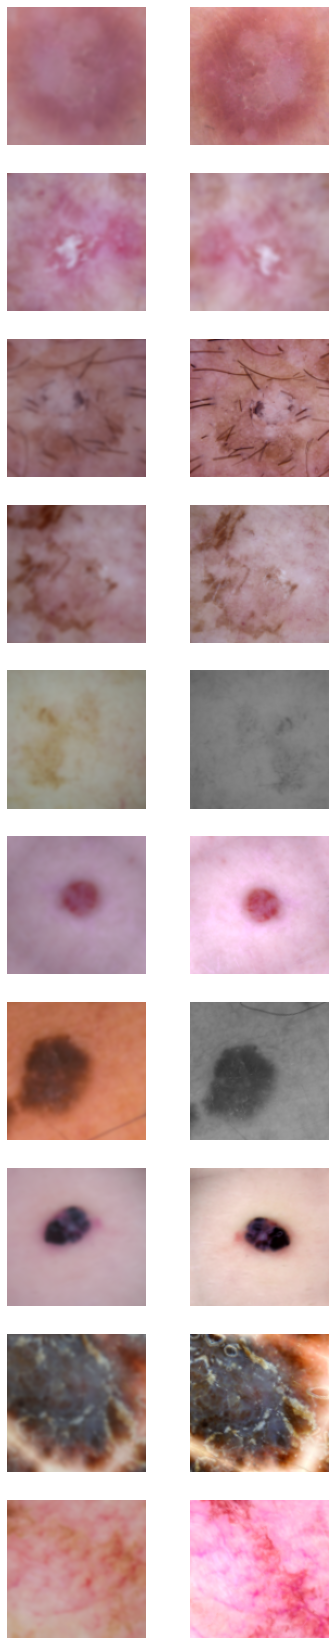

In [17]:
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p1, rotate_p=rotate_p,noise_p=noise_p1, jitter_p=jitter_p1, bw_p=bw_p1, blur_p=blur_p1,sol_p=sol_p1, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r,
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=noise_std, rotate_deg=rotate_deg,blur_s=blur_s,sol_t=sol_t,sol_a=sol_a, #hps of augs
                    flip_p=flip_p2, rotate_p=rotate_p,noise_p=noise_p2, jitter_p=jitter_p2, bw_p=bw_p2, blur_p=blur_p2,sol_p=sol_p2, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))#,P=0.0)


aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

show_bt_batch(dls=dls_tune,n_in=3,aug=aug_pipelines,n=10,print_augs=True)


## Augmentations for fine tuning

In [18]:
aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r_tune,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=None, rotate_deg=rotate_deg,blur_s=blur_s_tune,sol_t=None,sol_a=None, #hps of augs
                    flip_p=flip_p_tune, rotate_p=rotate_p_tune,noise_p=0.0, jitter_p=jitter_p_tune, bw_p=bw_p_tune, blur_p=blur_p_tune,sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))]#,P=0.0)

#show_linear_batch(dls=dls_tune,n_in=n_in,n=10,aug=aug_pipelines_tune,print_augs=True)

## Augmentations for testing (i.e. test time augmentations)

In [19]:
aug_pipelines_test = get_barlow_twins_aug_pipelines(size=size,blur_r=blur_r_tune,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=resize_scale,resize_ratio=resize_ratio,noise_std=None, rotate_deg=rotate_deg,blur_s=blur_s_tune,sol_t=None,sol_a=None, #hps of augs
                    flip_p=flip_p_tune, rotate_p=rotate_p_tune,noise_p=0.0, jitter_p=jitter_p_tune, bw_p=bw_p_tune, blur_p=blur_p_tune,sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


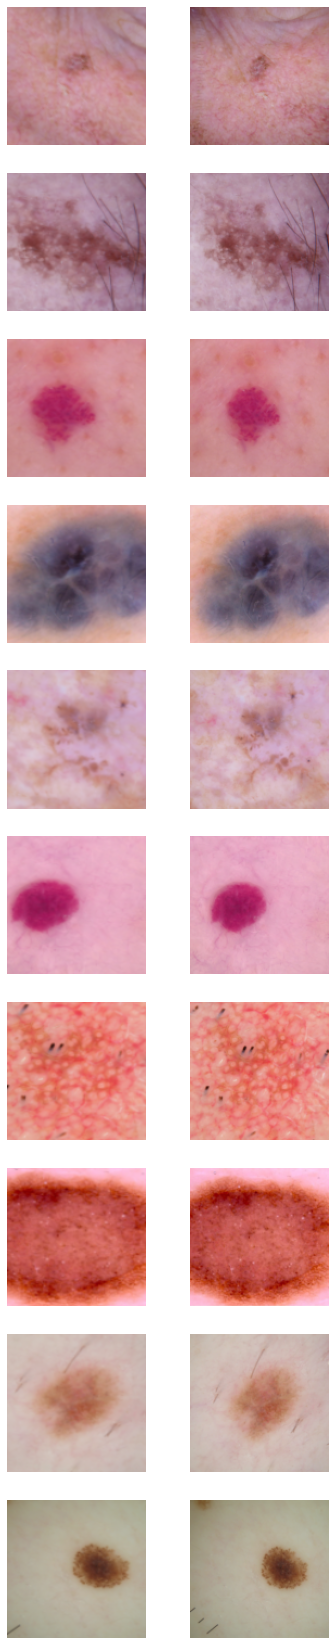

In [20]:
show_linear_batch(dls=dls_valid,n_in=n_in,n=10,aug=[aug_pipelines_test],print_augs=True)

## Train BT

## Load model: bt-pretrained, supervised-pretrained, or random-weights

In [21]:
def get_resnet_encoder(model):
    model = create_body(model, n_in=n_in, pretrained=False, cut=len(list(model.children()))-1)
    model.add_module('flatten', torch.nn.Flatten())
    return model


def create_model(which_model=None,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder


In [22]:
bt_model,encoder = create_model(which_model='supervised_pretrain')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
#test
model,encoder = create_model(which_model='bt_pretrain')
for p in model.parameters():
    test_eq(p.requires_grad,True)

Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

In [24]:
#test:
def sum_params(model):

    s=0
    for p in model.parameters():
        s+=p.sum()
    return s.item()

#Test that shape of encoder is 2048
_,e = create_model(which_model='bt_pretrain')
test_eq(e(x).shape[1],2048) 

#Test that pretrained models (encoders) have the same weights (roughyl) each time
_,e = create_model(which_model='bt_pretrain')
test_eq((sum_params(e)-175864.4062)<0.001,True)

_,e = create_model(which_model='supervised_pretrain')
test_eq((sum_params(e)-39438.5078125)<0.001,True)

#Test that non-pretrained model has diff (i.e. random) weights each time
_,e1 = create_model(which_model='no_pretrain')
_,e2 = create_model(which_model='no_pretrain')
test_ne(sum_params(e1),sum_params(e2))

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


## Train BT model

In [25]:
#Delete me?
# def train_encoder(aug_pipelines,initial_weights=None,pretrain=False):

#     model_path = f'/content/drive/My Drive/models/baseline_initial_weights={initial_weights}.pth'

#     model,encoder = create_model(which_model=initial_weights)
#     learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#     if pretrain: 

#         learn.fit(num_epochs)
#         torch.save(encoder.state_dict(), model_path)

#     return encoder


## How to load models we have trained:

In [26]:
#load models we have trained here 
# model_path = '/content/drive/My Drive/models/baselinebyol.pth'
# new_fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
# new_fastai_encoder.load_state_dict(torch.load(model_path))


## Fine tune and predict

In [27]:
#Fine tune and predict

@torch.no_grad()
def predict_model(xval,yval,model,numavg=3):
    
    model.eval()

    test_eq(model.encoder.training,False)

    N=xval.shape[0]

    scores=0
    for _ in range(numavg):

        scores += model(aug_pipelines_test(xval)) #test time augmentation. This also gets around issue of randomness in the dataloader in each session...

    scores *= 1/numavg

    ypred = cast(torch.argmax(scores, dim=1),TensorCategory)

    correct = (ypred == yval)#.type(torch.FloatTensor)

    #correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N
    
    return scores,ypred,accuracy.item()

#Please note, I had to edit this from before: was some weird stuff with TensorImage vs TensorCategory. Annoying, but whatever. 


In [28]:
#can import from RBT / whatever we name in future
class LinearModel(Module):
    """Linear model
    """
    def __init__(self,encoder,
                 indim=1024,#dimension of encoder output
                 outdim=10, #number of classes
                ):
        self.encoder=encoder
        self.L = nn.Linear(indim,outdim)
        
        if torch.cuda.is_available():
            self.L.to('cuda')
        
    def forward(self,x):return self.L(self.encoder(x))

In [29]:
#get scores and predictions using FastAI learner. 
@torch.no_grad()
def get_preds(dls_valid,model,yval=yval): #yval must be the entire set i.e. all of dls_valid.train


    learn = Learner(dls_valid,model)
    learn.model.eval()
    test_eq(model.encoder.training,False)

    scores,preds = learn.get_preds(dl=dls_valid.train)

    #Now we had preds, scores, can get acc, ROC etc

    acc = (yval.cpu() == preds).sum() / len(yval)

    return scores,preds, acc.item()


# if __name__ == '__main__':
#     model,encoder = create_model(which_model='no_pretrain')
#     model = LinearModel(encoder=encoder,indim=2048,outdim=9)
#     learn = Learner(dls_tune,model,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=n_in)],wd=0.0)

#     scores,preds, acc = get_preds(dls_valid,learn,yval=yval)
#     acc

## Metrics

In [30]:
from sklearn.metrics import classification_report

def classification_report_wrapper(ypred, y, vocab, print_report=True):
    # Convert ypred and y to numpy arrays
    ypred = ypred.cpu().numpy()
    y = y.cpu().numpy()
    
    # Get the class labels from vocab
    labels = [vocab[i] for i in range(len(vocab))]
    
    # Get the classification report as a dictionary
    report = classification_report(y, ypred, target_names=labels, output_dict=True)
    
    if print_report:
        print(classification_report(y, ypred, target_names=labels))
        
    return report

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(ypred, y, vocab):
    # Convert ypred and y to numpy arrays
    ypred = ypred.cpu().numpy()
    y = y.cpu().numpy()
    
    # Get the class labels from vocab
    labels = [vocab[i] for i in range(len(vocab))]
    
    # Create the confusion matrix
    cm = confusion_matrix(y, ypred)
    
    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    
    # Use seaborn to create a heatmap of the confusion matrix with blue and white colors
    sns.heatmap(df_cm, annot=True, cmap="Blues")



#Plot the roc and auc

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc(yval,ypred,vocab,print_plot=True):
    "plot 1 vs all roc curves"

    yval = yval.cpu().numpy()
    ypred = ypred.cpu().numpy()

    N=len(vocab)
    # Binarize the output
    y_true = label_binarize(yval, classes=list(range(N)))
    y_pred = label_binarize(ypred, classes=list(range(N)))

    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(N):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    auc_dict = dict(zip([vocab[i] for i in roc_auc.keys()],list(roc_auc.values()))) #just change keys from e.g. 0 to 'actinic keratosis'

    if print_plot == False: return auc_dict

    # Plot ROC for each class
    plt.figure(figsize=(7,5))
    lw = 2
    for i in range(N):
        plt.plot(fpr[i], tpr[i], lw=lw, label='{0} (area = {1:0.2f})'.format(vocab[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    #plt.legend(loc="lower right")
    plt.legend(loc="lower right", fontsize=8)
    

    return auc_dict

#auc_dict = plot_roc(yval=yval,ypred=preds,vocab=vocab,print_plot=False)

In [42]:
class Main:

    def __init__(self,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights=None, #Which initial weights to use
                 pretrain=None, #Whether to fit BT
                 fit_policy=None, #policy for fitting BT
                 numfit=None,
                 end=False

                 ):
                 store_attr()

   
                 self.model=None

                #  if self.initial_weights == 'supervised_pretrain':
                #     assert False  

                 self.bt_model,self.encoder = create_model(which_model=self.initial_weights)

                 #self.encoder_path = f'/content/drive/My Drive/models/baselineencoder_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'
                 #self.tuned_model_path = f'/content/drive/My Drive/models/baselinefinetuned_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'


    def train_encoder(self):


        if self.pretrain:

            learn = Learner(dls_train,self.bt_model, cbs=[BarlowTwins(self.aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])

            if self.fit_policy == 'fit_one_cycle':

                learn.fit_one_cycle(num_epochs)

            elif self.fit_policy == 'fit':
                learn.fit(num_epochs)

            elif self.fit_policy == 'fine_tune':
                learn.fine_tune(num_epochs)

            #torch.save(encoder.state_dict(), self.encoder_path)

        self.encoder=encoder

        return encoder

    def fine_tune(self):

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)
        
        if self.model == None:
            print("self.model was None")
            self.model = LinearModel(encoder=self.encoder,indim=2048,outdim=9)
        
        learn = Learner(dls_tune,self.model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=n_in)],wd=0.0)


        #We can do an ablation where we test bt_pretrain initial weights with fine_tune as well, 
        #in the case of pretrain=False

        #if self.initial_weights == 'supervised_pretrain': assert False

        if self.initial_weights == 'no_pretrain' or self.initial_weights =='supervised_pretrain':
            learn.fine_tune(self.numfit)


            # if self.end==False:
            #     learn.fit_one_cycle(numfit,lr_max=0.005,div=10,div_final=10,pct_start=0.5)
            
            # else:
            #     learn.fit_one_cycle(numfit,lr_max=0.001,div=10,div_final=100,pct_start=0.5)


        elif self.initial_weights == 'bt_pretrain':
            learn.fit(self.numfit)
    
        else:
            raise Exception('Initial weights not of required form')

        #scores, predictions, accuracy
        #scores,preds, acc = get_preds(dls_valid,learn,yval=yval)

        scores,preds, acc = predict_model(xval,yval,self.model,numavg=3)

        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, yval, vocab, print_report=False)
        metrics['acc'] = acc
        #metrics['scores'] = scores
        #metrics['preds'] = preds

        auc_dict = plot_roc(yval,preds,vocab,print_plot=False)
        metrics['auc_dict'] = auc_dict
        
        #torch.save(model.state_dict(), self.tuned_model_path)
        return metrics #

    def __call__(self):


        self.train_encoder() #train (or extract) the encoder
        metrics = self.fine_tune()

        # self.end=True
        # self.numfit=20

        return metrics

if __name__ == '__main__':
    foo='hi'

    #assert False


    #Main for training. Essentially a map from hyperparameters to validation acc (which can eventually be a dictionary etc)
    # numfit=60
    # numavg=1
    # num_epochs='na'

    # pretrain = False
    # initial_weights = 'supervised_pretrain'
    # fit_policy = 'na'

    # avg_acc = 0 
    # for _ in range(numavg):
    
    #     main = Main(initial_weights=initial_weights,
    #                     pretrain=pretrain,
    #                     aug_pipelines=aug_pipelines,
    #                     aug_pipelines_tune=aug_pipelines_tune,
    #                     aug_pipelines_test=aug_pipelines_test,
    #                     fit_policy = fit_policy, #i.e. we use fixed policy for these
    #                     numfit=numfit
    #                 )
    
    #     metrics = main()

    #     avg_acc +=  metrics['acc']

    #     del main

    # avg_acc *= 1/numavg

    # print(f'avg_acc is {avg_acc:.3f}')

    # print('no-pretrain')




## Experiment: Find good fit policy for supervised learning, for initial weights (no BT pretraining done)



In [35]:
#Helper function for this experiment

def avg_main_acc(config,numavg):

    acc_avg=0
    for _ in range(numavg):

        main = Main(initial_weights=config.initial_weights,
                        pretrain=config.pretrain,
                        aug_pipelines=aug_pipelines,
                        aug_pipelines_tune=aug_pipelines_tune,
                        aug_pipelines_test=aug_pipelines_test,
                        fit_policy = config.fit_policy, #i.e. we use fixed policy for these
                        numfit=config.numfit,

                    )
                            
        metrics = main()

        acc_avg += metrics['acc']

    
    return acc_avg/numavg


## Experiment: No pretrain baselines

In [43]:
numfit=60
numavg=1
num_epochs=60

#Lists of hps
initialweights = ['supervised_pretrain','bt_pretrain']
#fitpolicy = ['fine_tune','fit','fit_one_cycle']
fitpolicy = ['fit'] #keep it simple

tune_fit_dict = {'no_pretrain':'fine_tune','supervised_pretrain':'fine_tune','bt_pretrain':'fit'}

#cartesian product of hps
MyTuple = namedtuple('MyTuple', 'initialweights fitpolicy')
HPs = [MyTuple(x,y) for x,y in list(itertools.product(initialweights, fitpolicy))]

for hp in HPs: 

    weight = hp.initialweights
    fitpolicy = hp.fitpolicy

    config = dict(pretrain=True,initial_weights=weight,
                  fit_policy = fitpolicy,numfit=numfit,
                  num_epochs=num_epochs,numavg=numavg,
                  tune_fit_dict=tune_fit_dict
                  )

    name = f"initial_weight={weight}, fit_policy={fitpolicy}"

    wandb.init(
        # Set the project where this run will be logged
        project="pretrain-baselines", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=name,
            
        #Track hyperparameters and run metadata
        config=config)

    config = wandb.config

    avg_acc = avg_main_acc(config,numavg=numavg) 

    wandb.log({'avg_acc':avg_acc}) #log all the metrics for this experiment

    wandb.summary['avg_acc'] = avg_acc

#acc = 0.5
#Can also do stuff like this
#wandb.summary['acc'] = acc_dict

#Also make sure that you are running the code on a GPU, wandb needs GPU to log the metrics. (Thanks, ChatGPT!)

# wandb.log({'acc':acc}) #log metrics and stuff

# wandb.summary['acc'] = acc

    # # 🐝 Close wandb run 
    wandb.finish()


epoch,train_loss,valid_loss,time
0,4544.811035,None,00:06
1,3196.864746,None,00:07
2,2633.618652,None,00:07
3,2270.581055,None,00:06
4,2033.717529,None,00:07
5,1857.231934,None,00:07
6,1726.162354,None,00:06
7,1618.333130,None,00:07
8,1526.179321,None,00:07
9,1447.867920,None,00:07


Your generator is empty.


self.model was None


epoch,train_loss,valid_loss,time
0,2.134754,None,00:06


epoch,train_loss,valid_loss,time
0,1.661635,None,00:06
1,1.575366,None,00:06
2,1.482889,None,00:06
3,1.386760,None,00:06
4,1.290987,None,00:06
5,1.193599,None,00:06
6,1.096313,None,00:06
7,1.002549,None,00:06
8,0.911861,None,00:06
9,0.831436,None,00:06


avg_acc,▁
avg_acc,0.58046


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


epoch,train_loss,valid_loss,time
0,4034.520020,None,00:07
1,2743.154053,None,00:08
2,2181.416260,None,00:07
3,1872.331787,None,00:07
4,1671.718140,None,00:07
5,1525.405029,None,00:07
6,1414.094727,None,00:07
7,1320.015015,None,00:07
8,1239.067627,None,00:07
9,1172.264893,None,00:07


Your generator is empty.


self.model was None


epoch,train_loss,valid_loss,time
0,1.711055,None,00:06
1,1.146483,None,00:06
2,0.827767,None,00:06
3,0.636277,None,00:06
4,0.511815,None,00:06
5,0.429045,None,00:06
6,0.366361,None,00:06
7,0.318817,None,00:06
8,0.282437,None,00:06
9,0.252061,None,00:06


avg_acc,▁
avg_acc,0.5977
